# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [3]:
def read_image(image):
    return mpimg.imread('test_images/' + image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    imshape = img.shape
    vertices = np.array([vertices], dtype=np.int32)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    
    lines_divided = [[],[]]
    slopes = [[],[]]
    left_top_point = [0, math.inf]
    right_top_point = [0, math.inf]
    
    for line in lines:
        slope = ((line[0][3] - line[0][1]) / (line[0][2] - line[0][0]))
        if slope > 0 and slope < 1.15:
            slopes[1].append(slope)
            lines_divided[1].append(line)   
                       
        elif slope < 0 and slope > -1.15:
            slopes[0].append(slope)
            lines_divided[0].append(line)
    
    bottom = img.shape[0]
    
    x = get_bottom_x(lines_divided, slopes, bottom)
    
    cv2.line(img, (int(x[0]), 340), (int(x[1]), bottom), color, thickness)
    cv2.line(img, (int(x[2]), 340), (int(x[3]), bottom), color, thickness)
    
    
def get_bottom_x(lines, slopes, bottom):
    left_slope = np.average(slopes[0])
    right_slope = np.average(slopes[1])
    points_grouped = [[[], []], [[], []]] #points grouped by left and right x and y axes
    
    
    
    for line in lines[0]:
        for x1,y1,x2,y2 in line:
            points_grouped[0][0].extend([x1, x2])
            points_grouped[0][1].extend([y1, y2])

            
    for line in lines[1]:
        for x1,y1,x2,y2 in line:
            points_grouped[1][0].extend([x1, x2])
            points_grouped[1][1].extend([y1, y2])

            
    left_x1 = np.average(points_grouped[0][0])
    left_y1 = np.average(points_grouped[0][1])
    right_x1 = np.average(points_grouped[1][0])
    right_y1 = np.average(points_grouped[1][1])
    
    def get_x(x1, y1, slope, y):
        l = slope * -x1
        b = l + y1
        x = (y - b) / slope
        return x
        
    
    left_top_x = get_x(left_x1, left_y1, left_slope, 340)        
    left_bottom_x = get_x(left_x1, left_y1, left_slope, bottom)
    right_top_x = get_x(right_x1, right_y1, right_slope, 340)
    right_bottom_x = get_x(right_x1, right_y1, right_slope, bottom)
    
    return left_top_x, left_bottom_x, right_top_x, right_bottom_x

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):    
    return cv2.addWeighted(initial_img, α, img, β, λ)





## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

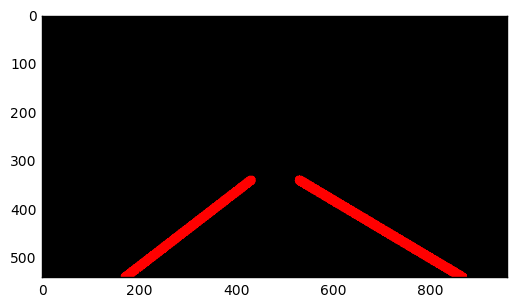

In [12]:
import os
image_dir = os.listdir("test_images/")
    

imagearr = []
for image in image_dir:
    read = read_image(image)
    size = read.shape
    gray = grayscale(read)
    gaussian = gaussian_blur(gray, 5)
    edges = canny(gaussian, 40, 200)
    region = region_of_interest(edges, [(500,315),(0, size[0]), (size[1], size[0])])
    hough = hough_lines(region, 1, np.pi/180, 25, 1, 1)
    imagearr.append(hough)
    lines_edges = weighted_img(hough, read)
#     imagearr.append(lines_edges)
    
plt.imshow(imagearr[3], cmap='Greys_r')


    









run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [62]:
def process_image(image):
    size = image.shape
    gray = grayscale(image)
    gaussian = gaussian_blur(gray, 5)
    edges = canny(gaussian, 40, 200)
    region = region_of_interest(edges, [(500,315),(0, size[0]), (size[1], size[0])])
    hough = hough_lines(region, 1, np.pi/180, 25, 1, 1)
    result = weighted_img(hough, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [63]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:09<00:00, 24.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:46<00:00, 14.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 48.7 s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

SUMMARY OF PIPELINE:
This pipeline first simplifies a series of images into lines and then those lines are converted to pixels using canny edge detection. I then used Hough transformation to define individual lines from those pixels. Those definitions consist of X,Y coordinates representing the end points of the lines. What I did with those lines is organize them into two groups(left, right) based on their slopes. I then got the average slope and average X and Y point for each group. I plugged this information into a y=mx+b equation to find the X end points that were used to draw the straight lines.

POTENTIAL IMPROVEMENTS:
If I could spend more time on this project I would dynamically determine the top of the line. As of now I'm using a fixed Y point in addition to the dynamically generated X point. I think this would be helpful in finding lane lines that might curve more. After this I would want to explore ways to curve the lines to follow lane lines on curved roads (turns). I would also want to continue fine tuning the parameters so that noise is fully reduced and the lines are delineated as clearly as possible. And of course I would try to make my code more efficient and organized.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [47]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:25<00:00,  9.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 29.1 s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))